# Vanilla Variational Autoencoder

In [1]:
# IMPORT
import numpy as np                             # for fast array manipulation
import torch                                   # Pytorch
import torchvision                             # contains image datasets and many functions to manipulate images
import torchvision.transforms as transforms    # to normalize, scale etc the dataset
from torch.utils.data import DataLoader        # to load data into batches (for SGD)
from torchvision.utils import make_grid        # Plotting. Makes a grid of tensors
from torchvision.datasets import MNIST         # the classic handwritten digits dataset
import matplotlib.pyplot as plt                # to plot our images
import torch.nn as nn                          # Class that implements a model (such as a Neural Network)
import torch.nn.functional as F                # contains activation functions, sampling layers and more "functional" stuff
import torch.optim as optim                    # For optimization routines such as SGD, ADAM, ADAGRAD, etc
from torch.distributions import MultivariateNormal
from math import log, pi

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Settings
batch_size = 100      # How many images to use for a SGD update
L = 1                 # Samples per data point. See section "Likelihood Lower Bound".
e_hidden = 500        # Number of hidden units in the encoder. Chosen based on AEVB paper page 7, section "Marginal Likelihood"
d_hidden = 500        # Number of hidden units in the decoder. Chosen based on AEVB paper page 7, section "Marginal Likelihood"
latent_dim = 2        # Chosen based on AEVB paper, page 7, section "Marginal Likelihood"
learning_rate = 0.001 # For SGD
weight_decay = 1e-5   # For SGD
epochs = 10        # Number of sweeps through the whole dataset, also called epochs

In [2]:
# Load Data
t = transforms.Compose([
                        transforms.ToTensor()
])

# Use transformation for both training and test set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=t)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=t)

# Load train and test set
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [3]:
# Encoder, Decoder and VAE
class Encoder(nn.Module):
  def __init__(self):
    """
    Encoder Network. Must inherit from `nn.Module` provided by Pytorch. We only need to define 2 things:
    
    1) The components of the network (layers, activation functions, etc). This is done in __init__().
    2) How the network uses such components to transform the network input into an output. This is done in a method called `forward()`.
    """
    super(Encoder, self).__init__()
    # Define Fully-Connected FeedForward Connections
    self.hidden = nn.Linear(in_features=28*28, out_features=e_hidden)
    # We need two separate layers. One is used for mu one is used for logvar.
    self.mu_layer     = nn.Linear(in_features=e_hidden, out_features=latent_dim)
    self.logvar_layer = nn.Linear(in_features=e_hidden, out_features=latent_dim)
    
  def forward(self, x):
    """Defines how the network transforms the input x into an encoded representation."""
    # Pass input through the first set of connections
    x = F.relu(self.hidden(x))
    # Now pass it to one set of connections to get mu, and to another set of connections 
    # to get logvar
    return self.mu_layer(x), self.logvar_layer(x)

class Decoder(nn.Module):
  def __init__(self):
    """
    Decoder Network. Works similarly to the encoder, except it takes an input from the latent space
    and then outputs an image.
    """
    super(Decoder, self).__init__()
    # Define Fully-Connected FeedForward Connections
    self.hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
    # Second set of FC connections. Here we only want one output
    self.output_layer = nn.Linear(in_features=d_hidden, out_features=28*28)

  def forward(self, z):
    """Defines how the network transforms the latent input z into a flatten image."""
    # Notice that we use a sigmoid function at the end to restrict output values between 
    # 0 and 1 so they can be interpreted as probabilities (?)
    z = F.relu(self.hidden(z))
    return torch.sigmoid(self.output_layer(z))

class VAE(nn.Module):
  def __init__(self):
    """Puts together Encoder & Decoder with the reparametrization trick."""
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def sample_latent(self, mu, logvar):
    if self.training:
      # Get standard normal in the shape of mu
      eps = torch.randn_like(mu)
      # Use logarithmic properties to transform logvar to std. Then multiply
      # and sum by latent mu
      return eps.mul(torch.exp(0.5*logvar)).add_(mu)
    else:   # This is used when testing 
      return mu    

  def forward(self, x):
    """Transforms image into latent and then back to its reconstruction."""
    # Feed image to encoder. Obtain mean and logvar for the latent space
    latent_mu, latent_logvar = self.encoder(x.view(-1, 28*28))
    # Sample from the latent space with the give mean and variance using the 
    # reparametrization trick
    z = self.sample_latent(latent_mu, latent_logvar)
    # Decode the latent representation
    return self.decoder(z), latent_mu, latent_logvar   

In [4]:
# Loss Function
def vae_loss(image, reconstruction, mu, logvar):
  """Loss for the Variational AutoEncoder."""
  # Compute the binary_crossentropy.
  # Notice that we reshape them because in practice we don't receive just 1 image and 1 reconstruction, but we receive a whole batch!
  reconstruction_loss = F.binary_cross_entropy(input=reconstruction.view(-1, 28*28), target=image.view(-1, 28*28), reduction='sum')
  # Compute KL divergence using formula (closed-form)
  kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return reconstruction_loss + kl

In [5]:
# Instantiate VAE
vae = VAE()

# Pass VAE to the device (GPU or CPU)
vae = vae.to(device)

# Use Stochastic Gradient Descent as optimizer
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set VAE to training mode
vae.train()

# Store all losses here
losses = []

for epoch in range(epochs):
  # Put a zero into losses. This is where we will cumulatively sum all the losses
  # from each batch. After all batches are done, we will divide by the number of batches
  # to obtain the average loss per batch
  losses.append(0)

  # To compute the number of batches (since it varies depending on dataset size)
  # update a counter variable
  number_of_batches = 0

  # Grab the batch, we are only interested in images not on their labels
  for images, _ in trainloader:
    # Store image batch to device
    images = images.to(device)

    # Set previous gradients to zero
    optimizer.zero_grad()

    # Feed images through the VAE to obtain their reconstruction
    reconstructions, latent_mu, latent_logvar = vae(images)

    # Compare reconstruction and images via the loss function
    loss = vae_loss(images, reconstructions, latent_mu, latent_logvar)

    # Backpropagate the loss. Before doing that, make sure all previously stored gradients are zero (e.g. from previous iterations)
    loss.backward()

    # Use the accumulated gradients to do a step in the right direction
    optimizer.step()

    # Add loss to the cumulative sum
    losses[-1] += loss.item()        #.item() grabs the value in a tensor with only 1 value
    number_of_batches += 1
  
  # At the end of all batches divide the total loss for this epoch by the number of 
  # batches to obtain an average loss per batch
  losses[-1] /= number_of_batches
  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, losses[-1]))    


Epoch [1 / 10] average reconstruction error: 18466.625936
Epoch [2 / 10] average reconstruction error: 16632.391872
Epoch [3 / 10] average reconstruction error: 16274.567900
Epoch [4 / 10] average reconstruction error: 16048.492209
Epoch [5 / 10] average reconstruction error: 15883.186273
Epoch [6 / 10] average reconstruction error: 15753.615415
Epoch [7 / 10] average reconstruction error: 15639.520076
Epoch [8 / 10] average reconstruction error: 15546.366307
Epoch [9 / 10] average reconstruction error: 15467.203861
Epoch [10 / 10] average reconstruction error: 15397.673185


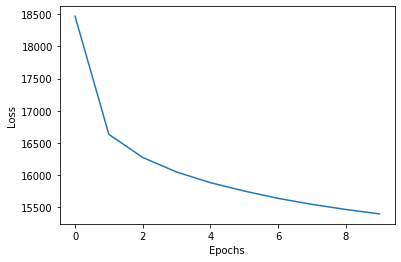

In [6]:
fig = plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# VAE with Normalizing Flows (Planar Flows)

### Theory of Vanilla VAE

In a vanilla VAE we feed $x$ into an encoder neural network and obtain $(\mu, \log \sigma)$. These are the parameters of our approximate distribution 

$$
q_{\phi}(z \mid x) = \mathcal{N}(z \mid \mu_{\phi}(x), \sigma^2_{\phi}(x) I)
$$

We then get a sample $z \sim q_{\phi}(z \mid x)$ by using the reparametrization trick $z = \mu + \sigma \epsilon$ where $\epsilon \sim \mathcal{N}(0, 1)$. We then use the following objective function

$$
\mathcal{L}_{\phi, \theta}(x) = \mathbb{E}_{q_{\phi}(z \mid x)}[\log p_{\theta}(x \mid z)] - \text{KL}(q_{\phi}(z \mid x) \parallel p(z))
$$

where we compute the KL divergence in closed form using 

$$
\text{KL}(q_{\phi}(z \mid x) \parallel p(z)) = -\frac{1}{2}\sum_{j=1}^{\text{dim}(z)} \left(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2\right)
$$

and we can compute the reconstruction error in two simple cases: Bernoulli and Normal. In the Bernoulli case (e.g. when working with images) we have

$$
p_{\theta}(x \mid z) = \prod_{i=1}^{\text{dim}(x)} p_i(z)^{x_i}(1 - p_i(z))^{1 - x_i}
$$
where
$$
p = (p_1(z), \ldots, p_{\text{dim}(x)}(z))^\top 
$$
is the output of the decoder network: $z \longrightarrow $ Decoder $ \longrightarrow p \in [0, 1]^{\text{dim}(x)}$. This means that we can write the reconstruction error as:

$$
\begin{align}
    \mathbb{E}_{q_{\phi}(z \mid x)}[\log p_{\theta}(x \mid z)]
    &=  \mathbb{E}_{q_{\phi}(z \mid x)}\left[\log \prod_{i=1}^{\text{dim}(x)} p_i(z)^{x_i}(1 - p_i(z))^{1-  x_i}\right] \\
    &= \mathbb{E}_{q_{\phi}(z \mid x)}\left[\sum_{i=1}^{\text{dim}(x)} x_i \log p_i(z) + (1 - x_i) \log(1 - p_i(z))\right] \\
    &\approx \sum_{j=1}^{n_{z}}\sum_{i=1}^{\text{dim}(x)} x_i \log p_i(z) + (1 - x_i) \log(1 - p_i(z)) \qquad z^{(j)} \sim q_{\phi}(z \mid x)
\end{align}
$$

where $n_z$ is the number of samples that we sample from $q_{\phi}(z \mid x)$. Usually, we simply set $n_z = 1$, that is we only sample one latent variable for each datapoint. This leads to the following objective function:

$$
\mathcal{L}_{\phi, \theta}(x) = \sum_{i=1}^{\text{dim}(x)} x_i \log p_i(z^{(j)}) + (1 - x_i) \log(1 - p_i(z^{(j)})) +\frac{1}{2}\sum_{j=1}^{\text{dim}(z)} \left(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2\right)
$$

which was coded as follow:

```python
def vae_loss(image, reconstruction, mu, logvar):
  """Loss for the Variational AutoEncoder."""
  # Compute the binary_crossentropy.
  recon_loss = F.binary_cross_entropy(
      input=reconstruction.view(-1, 28*28),    # input is p(z) (the mean reconstruction)
      target=image.view(-1, 28*28),            # target is x   (the true image)
      reduction='sum'                          
  )
  # Compute KL divergence using formula (closed-form)
  kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return reconstruction_loss + kl
```

### Theory of Normalizing Flows VAE

Here we not only want our Encoder to output $(\mu, \log \sigma)$ to shift and scale our standard normal $\epsilon \sim \mathcal{N}(0, 1)$. We also want to feed it through a series of transformations depending on some parameters $\lambda$. In particular, we would like our Encoder to work as follows:

$$
x \longrightarrow \text{Encoder} \longrightarrow (\mu, \log\sigma, \lambda)
$$

then we would use $(\mu, \log\sigma)$ to compute $z_0$ using the reparametrization trick

$$
z_0 = \mu + \sigma \epsilon \qquad \epsilon \sim \mathcal{N}(0, 1)
$$

and finally, we would feed $z_0$ into a series of transformation (with parameters $\lambda$) to reach the final $z_K$:

$$
z_K = f_K \circ \ldots \circ f_2 \circ f_1(z_0)
$$

This means that our approximating distribution would not be 

$$
q_{\phi}(z \mid x) = \mathcal{N}(z \mid \mu_{\phi}(x), \sigma^2_{\phi}(x) I)
$$

anymore but rather, we would have $q_0(z_0)=\mathcal{N}(z_0 \mid \mu_{\phi}(x), \sigma_{\phi}^2(x) I)$ and 
(using the change of variables formula)

$$
\ln q_{\phi}(z \mid x) = \ln q_K(z_K) = \ln q_0(z_0) - \sum_{k=1}^K \ln \left|\text{det}\frac{\partial f_k}{\partial z_{k-1}}\right|.
$$
Thanks to the law of the uncounscious statistician we now know that 

$$
\begin{align}
\mathcal{L}_{\phi, \theta}(x) 
&= \mathbb{E}_{q_{\phi}(z \mid x)}[\log p_{\theta}(x \mid z)] - \text{KL}(q_{\phi}(z \mid x) \parallel p(z)) \\
&= \mathbb{E}_{q_K(z_K)}[\log p_{\theta}(x \mid z_K)] - \mathbb{E}_{q_K(z_K)}[\log q_K(z_K) - \log p(z_K)] \\
&= \mathbb{E}_{q_0(z_0)}[\log p_{\theta}(x \mid f_K \circ \ldots \circ f_2 \circ f_1(z_0))] - \mathbb{E}_{q_0(z_0)}[\log q_K(f_K \circ \ldots \circ f_2 \circ f_1(z_0)) - \log p(f_K \circ \ldots \circ f_2 \circ f_1(z_0))]
\end{align}
$$

as usual, we can approximate this with Monte Carlo by drawing samples $z_0 \sim q_0(z_0) = N(\mu, \sigma^2 I)$

$$
\mathcal{L}_{\phi, \theta}(x) \approx \sum_{j=1}^{n_z}\log p_{\theta}(x \mid f_K \circ \ldots \circ f_2 \circ f_1(z_0^j)) - \left[\sum_{j=1}^{n_z}\log q_K(f_K \circ \ldots \circ f_2 \circ f_1(z_0^j)) - \log p(f_K \circ \ldots \circ f_2 \circ f_1(z_0^j))\right]
$$

Again, in practice we use only one sample

$$
\begin{align}
\mathcal{L}_{\phi, \theta}(x) 
&\approx \left[\sum_{i=1}^{\text{dim}(x)} x_i \log p_i(z_K) + (1 - x_i) \log(1 - p_i(z_K))\right] - \log q_K(z_K) + \log p(z_K) \\
&= -\text{BCE}(X, z_K) - (\log q_0(z_0) + \text{LADJ}) + \log p(z_K) \\
&= -\text{BCE}(X, z_K) - \log q_0(z_0) - \text{LADJ} + \log p(z_K)
\end{align}
$$
Pycharm however does minimization only, so our objective becomes
$$
\text{BCE}(X, z_K) + \log q_0(z_0) + \text{LADJ} -\log p(z_K)
$$
Using temperature we then have
$$
\begin{align}
    \text{objective} 
    &= -\sum_{i=1}^{\text{dim}(x)} x_i \log p_i(z_K) + (1 - x_i) \log(1 - p_i(z_K)) \\
    &\quad -\frac{d}{2}\log(2\pi) -\frac{1}{2}\log \text{det}(\text{Diag}(\sigma^2))- \frac{1}{2}(x-\mu)^\top \text{Diag}\left(\frac{1}{\sigma^2}\right)(x - \mu) \\
    &\quad -\sum_{k=1}^K \log |1 + u_k^\top (1 - \tanh^2(w_k^\top z_{k-1} + b_k))w_k| \\
    &\quad -\frac{d}{2}\log(2\pi) -\frac{1}{2}x^\top x
\end{align}
$$

In our case we use the transformation

$$
f(z) = u h(w^\top z + b) \qquad u, w \in \mathbb{R}^{\text{dim}(z)\times 1} \qquad b\in\mathbb{R} \qquad h(\cdot)  =\tanh(\cdot)
$$

It's Log-Absolute-Determinant-Jacobian (LADJ) is given by

$$
\log \left|\text{det}\frac{\partial f}{\partial z}\right| = \log |1 + u^\top h'(w^\top z + b)w|
$$

where $h'$ is the derivative of $h$ and when $h = \tanh$ we have
$$
h'(\cdot) = 1 - \tanh^2(\cdot)
$$

If we apply this transformation $K$ times we get 

$$
\text{LADJ} = -\sum_{k=1}^K \log |1 + u_k^\top (1 - \tanh^2(w_k^\top z_{k-1} + b_k))w_k|
$$

**NOTE**: we have a different set of $\lambda_k = \{w_k, u_k, b_k\}$ for every transformation. 

Finally, not all transformations like this are invertible. One way to obtain an invertible transformation is by modifying $u$ after it has come out of the encoder, and replace it with

$$
\widehat{u} = u + \left[-1 + \log(1 + e^{w^\top u}) - w^\top u\right] \frac{w}{\parallel w \parallel^2}
$$

### Vanilla VAE - Minimal

In [ ]:
class VAE_vanilla(nn.Module):
    def __init__(self, e_hidden, d_hidden, latent_dim):
        """Variational Auto-Encoder Class"""
        super(VAE, self).__init__()
        # Encoding Layers
        self.e_input2hidden = nn.Linear(in_features=784, out_features=e_hidden)
        self.e_hidden2mean = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        self.e_hidden2logvar = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        
        # Decoding Layers
        self.d_latent2hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
        self.d_hidden2image = nn.Linear(in_features=d_hidden, out_features=784)
        
    def forward(self, x):
        # Shape Flatten image to [batch_size, input_features]
        x = x.view(-1, 784)
        
        # Feed x into Encoder to obtain mean and logvar
        x = F.relu(self.e_input2hidden(x))
        mu, logvar = self.e_hidden2mean(x), self.e_hidden2logvar(x)
        
        # Sample z from latent space using mu and logvar
        if self.training:
            z = torch.randn_like(mu).mul(torch.exp(0.5*logvar)).add_(mu)
        else:
            z = mu
        
        # Feed z into Decoder to obtain reconstructed image. Use Sigmoid as output activation (=probabilities)
        x_recon = torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z))))
        
        return x_recon, mu, logvar

### Method 1: Amortized

Recall that our input $x$ to the encoder will actually be of size $(\text{batch_size}, 784)$. This means that the outputs of the Encoder (in this amortized version) will have dimensions:

- $\mu$ has dimension $(\text{batch_size}, 2)$
- $\log \sigma^2$ has dimensions $(\text{batch_size}, 2)$
- $w$, and $u$ have dimensions $(\text{batch_size}, 2)$
- $b$ has dimensions $(\text{batch_size}, 1)$

This means that when computing $w^\top z_k$ we need to be careful. The only way to make this work with batch matrices is by computing 

In [22]:
class VAE_PF_amortized(nn.Module):
    def __init__(self, e_hidden, d_hidden, latent_dim, K):
        """VAE with Planar Flows - Amortized"""
        super(VAE_PF_amortized, self).__init__()
        # Encoding Layers
        self.e_input2hidden = nn.Linear(in_features=784, out_features=e_hidden)
        self.e_hidden2mean = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        self.e_hidden2logvar = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        self.e_hidden2w = nn.Linear(in_features=e_hidden, out_features=latent_dim*K) # AMORTIZED!
        self.e_hidden2u = nn.Linear(in_features=e_hidden, out_features=latent_dim*K) # AMORTIZED!
        self.e_hidden2b = nn.Linear(in_features=e_hidden, out_features=K)          # AMORTIZED!
        
        # Decoding Layers
        self.d_latent2hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
        self.d_hidden2image = nn.Linear(in_features=d_hidden, out_features=784)
        
        # Store setting
        self.K = K
        
    def encode(self, x):
        x = F.relu(self.e_input2hidden(x))
        # mu, sigma for latent space
        mu, logvar = self.e_hidden2mean(x), self.e_hidden2logvar(x)
        # parameters for normalizing flow
        w, u, b = self.e_hidden2w(x), self.e_hidden2u(x), self.e_hidden2b(x)
        # reshape
        batch_size = x.size(0)
        w = w.view(batch_size, self.K, 1, latent_dim)
        u = u.view(batch_size, self.K, latent_dim, 1)  # this is inverted so we can do dot product later
        b = b.view(batch_size, self.K, 1, 1)
        return mu, logvar, w, u, b
    
    def flow(self, z0, w, u, b):
        z_k = z0
        ladj_sum = torch.zeros((100, 1))
        
        # Feed z0 into flow. 
        for k in range(self.K):
            # Grab parameters for this flow
            w_k = w[:, k, :, :]   # (batch_size, 1, 2)
            u_k = u[:, k, :, :]   # (batch_size, 2, 1)
            b_k = b[:, k, :, :]   # (batch_size, 1, 1)
            # z0: (batch_size, 2, 1)            
            
            # Obtain u_hats so that transformations are invertible (see paper appendix).
            # This part is taken from https://github.com/federicobergamin/Variational-Inference-with-Normalizing-Flows/blob/master/flows_with_amortized_weights.py
            uw = torch.bmm(w_k, u_k)  # size (batch_size, 1, 1) basically a dot product for each batch
            m_uw = -1 + F.softplus(uw) # size (batch_size, 1, 1)
            # w has shape (batch_size, 1, 2). Transpose last two dimensions so it has size (batch_size, 2, 1) same as u
            uhat_k = u_k + ((m_uw - uw)* w_k.transpose(2, 1) / (torch.norm(w_k, dim=2, keepdim=True)**2))
            #print("### DIM1: ", (m_uw - uw).size())
            #print("### DIM2: ", w_k.transpose(2, 1).size())
            #print("### DIM3: ", ((m_uw - uw)* w_k.transpose(2, 1)).size())
            #print("### DIM4: ", (torch.norm(w_k, dim=2, keepdim=True)**2).size())
            # Now we use uhat instead of u. Since w_k is (batch_size, 2, 1) and zk has dimension 
            # (batch_size, 2, 1) we can do batch matrix multiplication with torch.bmm(). 
            # uhat has dimensions (batch_size, 2, 1) and similarly does z_k. The tanh term has dimensions
            # (batch_size, 1, 1). The resulting z_{k+1} will thus have dimensions (batch_size, 2, 1).
            # For this reason, we squeeze the last dimension out to get (batch_size, 2).
            wz_plus_b = torch.bmm(w_k, z_k)+ b_k
            #print("thing to be added: ", (uhat_k * torch.tanh(wz_plus_b))[:2, 0, 0])
            #print("uhat_k: ", uhat_k[:2, 0,0])
            #print("factor: ", torch.tanh(wz_plus_b)[:2, 0, 0])
            z_k_plus_1 = (z_k + uhat_k * torch.tanh(wz_plus_b)).squeeze(2)
            
            h_prime = (1 - torch.tanh(wz_plus_b)**2)
            #print("h_prime: ", h_prime.sum())
            #print("bmm: ", torch.bmm(h_prime*w_k, uhat_k).sum())
            #print("abs: ", (1 + torch.bmm(h_prime*w_k, uhat_k)).abs().sum())
            #print("add: ", (1 + torch.bmm(h_prime*w_k, uhat_k)).abs().add(1e-8).sum())
            #print("log: ", (1 + torch.bmm(h_prime*w_k, uhat_k)).abs().add(1e-8).log().sum())
            #print("log size: ", (1 + torch.bmm(h_prime*w_k, uhat_k)).abs().add(1e-8).log().size())
            #print("LOL : ", -(1 + torch.bmm(h_prime*w_k, uhat_k)).abs().add(1e-8).log().squeeze(2).sum())
            # Compute LADJ. Would be of size (batch_size, 1, 1) so we squeeze out the last dimension.
            ladj = -(1 + torch.bmm(h_prime*w_k, uhat_k)).abs().add(1e-8).log().squeeze(2)
            #ladj = -torch.log(torch.abs(1 + ))
            #wz_plus_b
            ladj_sum += ladj
            #print("ladj: ", ladj.size())
            # Set current z_k to the new one
            zk = z_k_plus_1
            #print("-"*80)
        
        z0, z_k = z0.squeeze(2), z_k.squeeze(2)
        return z0, zk, ladj_sum
    
    def decode(self, z0):
        z0, z_k = self.flow(z0)
        return torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z_k))))
        
        
    def forward(self, x):
        # Shape Flatten image to [batch_size, input_features]
        x = x.view(-1, 784)
        
        mu, logvar, w, u, b = self.encode(x)
        # Feed x into Encoder to obtain mean and logvar 
        #x = F.relu(self.e_input2hidden(x))
        #mu, logvar = self.e_hidden2mean(x), self.e_hidden2logvar(x)  # (batch_size, latent_dim)
        # Get also amortized parameters for the flow
        # w has dimensions (batch_size, latent_dim*K)
        # u has dimensions (batch_size, latent_dim*K)
        # b has dimensions (batch_size, K)
        #w, u, b = self.e_hidden2w(x), self.e_hidden2u(x), self.e_hidden2b(x)
        
        # Reshape so we can do computations "across batch size"
        #batch_size = x.size(0)
        #w = w.view(batch_size, self.K, 1, latent_dim)
        #u = u.view(batch_size, self.K, latent_dim, 1)  # this is inverted so we can do dot product later
        #b = b.view(batch_size, self.K, 1, 1)
        
        # Sample z0 from latent space using mu and logvar
        # z0 has size (batch_size, latent_dim) but we add an extra dimension to be able to do batch 
        # computations. z0 becomes (batch_size, latent_dim, 1)
        if self.training:
            z0 = torch.randn_like(mu).mul(torch.exp(0.5*logvar)).add_(mu).unsqueeze(2)
        else:
            z0 = mu.unsqueeze(2)
                  
        #z0, z_k = self.flow(z0)
        #print("After NF, after squeezing.")
        #print("z0: ", z0.size())
        #print("z_k: ", z_k.size())
        
        # Now feed z_K into the decoder to obtain p vector (mean reconstruction)
        #recon = torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z_k))))
        #print("recon: ", recon.size())
        z0, z_k, ladj_sum = self.flow(z0, w, u, b)
        recon = torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z_k))))
        
        
        # Compute KL divergence. First of all we need to compute logq0
        # Should be (batch_size, 1)
        #print("z0-mu:", (z0-mu).size())
        #print("2*torch.exp(logvar):", (2*torch.exp(logvar)).size())
        #print("(z0 - mu)/(2*torch.exp(logvar): ", ((z0 - mu)/(2*torch.exp(logvar))).size())
        #print("((z0 - mu)/(2*torch.exp(logvar))).unsqueeze(1): ", (((z0 - mu)/(2*torch.exp(logvar))).unsqueeze(1)).size())
        #print("(z0-mu).unsqueeze(2): ", ((z0-mu).unsqueeze(2)).size())
        #print("bmm: ", (torch.bmm(((z0 - mu)/(2*torch.exp(logvar))).unsqueeze(1), (z0-mu).unsqueeze(2))).size())
        #print("bmm squeeze: ", (torch.bmm(((z0 - mu)/(2*torch.exp(logvar))).unsqueeze(1), (z0-mu).unsqueeze(2)).squeeze(2)).size())
        #print("logvar sum: ", logvar.sum(dim=1, keepdim=True).size())
        log_q0 = -log(2*pi) -logvar.add(1e-8).sum(dim=1, keepdim=True) - torch.bmm(((z0 - mu).add(1e-8)/(2*torch.exp(logvar))).unsqueeze(1), (z0-mu).unsqueeze(2)).squeeze(2)
        #print("log_q0: ", log_q0.size())
        #print("ladj_sum: ", ladj_sum.size())
        # Now compute log_qk by subtracting ladj_sum to log_q0
        ############### IMPORTANT, I'VE COMMENTED THIS ONE OUT TO TEST IT
        #log_qK = log_q0 + ladj_sum
        #####################################################################
        #print("log_qK: ", log_qK.size())
        # Finally compute log p(z_K) for the prior. Recall zk is (batch_size, 2) so essentially we compute the
        # batch multiplication between z_k with dimension (batch_size, 1, 2) and (batch_size, 2, 1) so that
        # the result is (batch_size, 1, 1). Then we squeeze out the last dimension to obtain (batch_size, 1)
        log_pK = -log(2*pi) -0.5*torch.bmm(z_k.unsqueeze(1), z_k.unsqueeze(2)).squeeze(2).add(1e-8)
        #print("log_pK: ", log_pK.size())
        #print("kl: ", (log_qK - log_pK).size())
        # return reconstruction and terms for kl divergence
        return recon, log_q0, ladj_sum, log_pK

In [23]:
def vae_pf_loss(x, recon, log_qk, log_pk, beta):
    """Loss for VAE with PF"""
    #print("-"*80)
    #print("Inside VAE loss")
    #print("x: ", x.size())
    #print("recon: ", recon.size())
    #print("kl: ", kl.size())
    #print("VAE Loss. x range ({}, {})".format(x.min(), x.max()))
    #print("VAE Loss. recon range ({}, {})".format(recon.min(), recon.max()))
    #print("VAE Loss. recon nans: ",torch.isnan(recon.view(-1)).sum())
    #print("recon loss: ", recon_loss.size())
    #print("recon_loss: ", recon_loss)
    #BCE = F.binary_cross_entropy(recon.view(-1, 784), x.view(-1, 784), reduction='sum')
    #KL  = (log_qk - beta*log_pk).sum()
    return 0 #beta*BCE + KL

In [24]:
# Instantiate VAE
vae_pf = VAE_PF_amortized(e_hidden, d_hidden, latent_dim, K=3)

# Pass VAE to the device (GPU or CPU)
vae_pf = vae_pf.to(device)

# Use Stochastic Gradient Descent as optimizer
optimizer_pf = optim.Adam(params=vae_pf.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set VAE to training mode
vae_pf.train()

# Store all losses here
losses_pf = []

# Use a temperature for the objective function
t = 0

for epoch in range(epochs):
    # Put a zero into losses. This is where we will cumulatively sum all the losses
    # from each batch. After all batches are done, we will divide by the number of batches
    # to obtain the average loss per batch
    losses_pf.append(0)

    # To compute the number of batches (since it varies depending on dataset size)
    # update a counter variable
    number_of_batches = 0

    # Grab the batch, we are only interested in images not on their labels
    for images, _ in trainloader:
        beta = 1.0 #min(1, 0.01 + t / 700)
        # Store image batch to device
        images = images.to(device)

        # Set previous gradients to zero
        optimizer_pf.zero_grad()

        # Feed images through the VAE to obtain their reconstruction
        recon_pf, log_q0, ladj_sum, log_pK = vae_pf(images)


        # Compare reconstruction and images via the loss function
        #print("-"*80)
        #print("Batch: ", number_of_batches)
        #print("Training Loop")
        #print("images size: ", images.size())
        #print("recon_pf size: ", recon_pf.size())
        #print("kl_pf size: ", kl_pf.size())
        BCE = F.binary_cross_entropy(recon_pf.view(-1, 784), images.view(-1, 784), reduction='sum')
        #print("log_qK: ", log_qK.sum())
        #print("log_pK: ", log_pK.sum())
        #print("log_q0: ", log_q0.sum())
        #print("ladj  : ", ladj_sum.sum())
        KL  = (log_q0 + ladj_sum - beta*log_pK).sum()
        #print("BCE : ", BCE)
        #print("KL  : ", KL)
        #print("beta: ", beta)
        loss_pf = beta*BCE + KL
        #print("loss_pf: ", loss_pf)
        #print("type(loss_pf): ", type(loss_pf))

        # Backpropagate the loss. Before doing that, make sure all previously stored gradients are zero (e.g. from previous iterations)
        loss_pf.backward()

        # Use the accumulated gradients to do a step in the right direction
        optimizer_pf.step()

        # Add loss to the cumulative sum
        losses_pf[-1] += loss_pf.item()        #.item() grabs the value in a tensor with only 1 value
        number_of_batches += 1
        t += 1

    # At the end of all batches divide the total loss for this epoch by the number of 
    # batches to obtain an average loss per batch
    losses_pf[-1] /= number_of_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, losses_pf[-1]))    


Epoch [1 / 10] average reconstruction error: 18068.218122
Epoch [2 / 10] average reconstruction error: 15782.609670
Epoch [3 / 10] average reconstruction error: 15235.382275
Epoch [4 / 10] average reconstruction error: 14921.211912
Epoch [5 / 10] average reconstruction error: 14754.922241
Epoch [6 / 10] average reconstruction error: 14591.640799
Epoch [7 / 10] average reconstruction error: 14394.930627
Epoch [8 / 10] average reconstruction error: 14287.859533
Epoch [9 / 10] average reconstruction error: 14204.706882
Epoch [10 / 10] average reconstruction error: 14102.411489


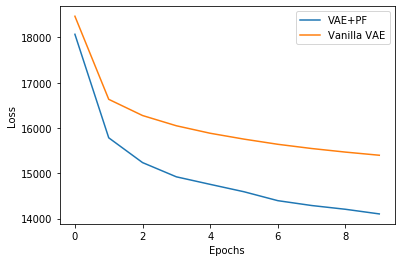

In [25]:
fig = plt.figure()
plt.plot(losses_pf)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["VAE+PF", "Vanilla VAE"])
plt.show()